# Product recommendation System

## Importing Libraries and Dataset

In [2]:
# !pip install -q opendatasets

In [67]:
# import opendatasets as od
# link = "https://www.kaggle.com/datasets/vibivij/amazon-electronics-rating-datasetrecommendation/download?datasetVersionNumber=1"
# od.download(link)

### Importation des bibliothèques

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds

### Importation du dataset

In [5]:
df = pd.read_csv('/content/data/ratings_electronics.csv', header=None)

Ajout des noms de colonnes

In [6]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [7]:
df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Suppression de la colonne "timestamp"

In [8]:
df = df.drop('timestamp', axis=1)
df = df.copy(deep=True)

In [9]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


## Exploratory Data Analysis

Vérifier :
- forme
- le type de données
- valeurs manquantes

Enfin, obtenir le résumé et vérifier :
- la distribution des avis.
- nombre d'utilisateurs et de produits.
- Utilisateurs ayant le plus grand nombre des avis

### Shape

In [10]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


### Datatypes

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### Détection des valeurs manquantes

In [12]:
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### Summary

Statistiques résumé de la variable "rating"

In [13]:
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Rating distribution

Création de diagrammes et fournir des observations

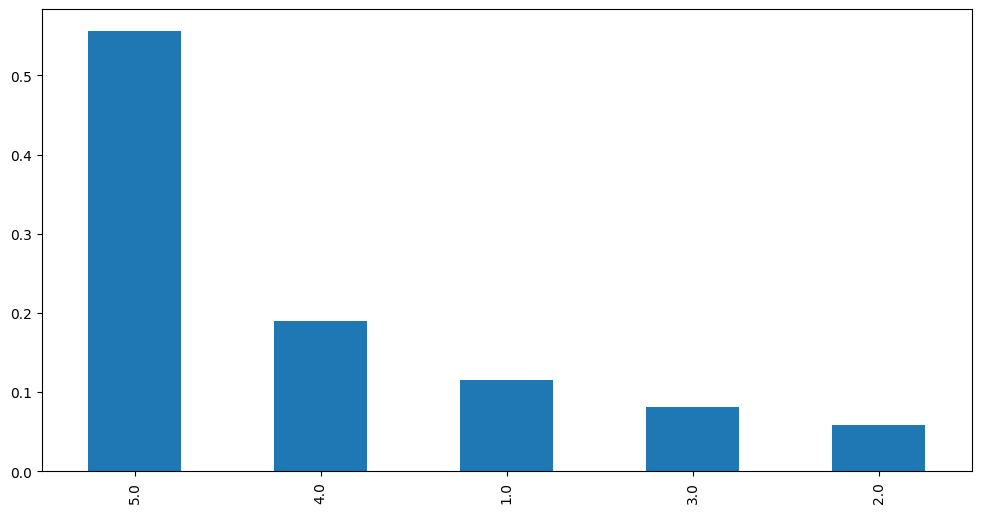

In [14]:
plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

La distribution est décalée vers la droite. Plus de 50 % des avis sont des avis 5 étoiles, suivis d'un peu moins de 20 % d'avis 4 étoiles.

Les pourcentages d'évaluation continuent de diminuer jusqu'à ce que moins de 10 % des évaluations soient des évaluations à 2 étoiles.

### Nombre d'utilisateurs et produits uniques

In [15]:
print("Nombre d'utilisateurs uniques = ", df['user_id'].nunique())
print("Nombre des produits uniques = ", df['prod_id'].nunique())

Nombre d'utilisateurs uniques =  4201696
Nombre des produits uniques =  476002


### Utilisateurs ayant le plus grand nombre d'avis

Top 10 Utilisateurs

In [16]:
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

## Pre-Processing

Prenons un sous-ensemble de dataset (en ne gardant que les utilisateurs qui ont donné 50 avis ou plus) pour rendre le dataset moins sparse et plus facile à travailler.

In [17]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [18]:
df_final.describe()

,rating
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [19]:
print("Le nombre d'observations dans les données finales =", len(df_final))
print("Nombre d'utilisateurs uniques dans les données finales = ", df_final['user_id'].nunique())
print('Nombre des produits uniques dans les données finales = ', df_final['prod_id'].nunique())

Le nombre d'observations dans les données finales = 125871
Nombre d'utilisateurs uniques dans les données finales =  1540
Nombre des produits uniques dans les données finales =  48190


- Le dataframe ```df_final``` contient les utilisateurs qui ont faire 50 avis ou plus
- Nous utiliserons ```df_final``` pour construire des systèmes de recommandation.

### Vérification de la densité de la matrice des avis

Création de la matrice d'interaction entre les produits et les utilisateurs basée sur les avis et remplacement de NaN par 0

In [20]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (1540, 48190)


Détermination du nombre d'entrées non nulles dans la matrice d'interaction

In [21]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

given_num_of_ratings =  125871


Détermination du nombre possible d'avis en fonction du nombre d'utilisateurs et de produits

In [22]:
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

possible_num_of_ratings =  74212600


Densité des avis

In [23]:
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

density: 0.17%


In [24]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## Aproaches :

## Aproaches :

## Method 1 : Rank Based Recommendation System

Calculate the average rating for each product

In [25]:
average_rating = df_final.groupby('prod_id')['rating'].mean()

Calculate the count of ratings for each product

In [26]:
count_rating = df_final.groupby('prod_id').count()['rating']

Create a dataframe with calculated average and count of ratings

In [27]:
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

Sort the dataframe by average of ratings

In [28]:
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

In [29]:
final_rating.head()

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


Définition d'une fonction permettant d'obtenir les n meilleurs produits en fonction de rating moyenne la plus élevée et du minimum d'interactions

In [30]:
def top_n_products(final_rating, n, min_interaction):

    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

### Exemple

- Recommandation des 5 meilleurs produits avec un minimum de 50 interactions en fonction de leur popularité

In [31]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

- Recommandation des 5 meilleurs produits avec un minimum de 100 interactions en fonction de leur popularité

In [32]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

#### Evaluation :

In [33]:
# Calculate the average popularity of recommended products
def evaluate_rank_based_recommendation(df_final, top_n, min_interaction):
    average_rating = df_final.groupby('prod_id')['rating'].mean()
    count_rating = df_final.groupby('prod_id').count()['rating']
    final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
    final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

    top_products = final_rating[final_rating['rating_count'] > min_interaction].index[:top_n]

    return top_products

In [34]:
top_products_rank_based = evaluate_rank_based_recommendation(df_final, top_n=5, min_interaction=50)
print("Top Products (Rank Based):", top_products_rank_based)

Top Products (Rank Based): Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')


---

## Method 2 : Collaborative Filtering based Recommendation System

### User based collaborative filtering

In [35]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous remplacerons l'identifiant de l'utilisateur par des nombres allant de 0 à 1539 (pour tous les identifiants d'utilisateur) de sorte que l'index soit de type entier et représente un identifiant d'utilisateur dans le même format.

In [36]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

Rating réelles attribuées par les utilisateurs à chaque produit

In [37]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fonction de recherche des utilisateurs similaires et de leurs scores de similarité

Définition d'une fonction pour obtenir des utilisateurs similaires

In [38]:
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): # ici .shape[0] renvoie le nombre des lignes

        #recherche de la "cosine similarity" entre user_id et chaque utilisateur
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Ajouter l'utilisateur et le score de similarité correspondant à user_id sous la forme d'un tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)

    #Extraction de l'utilisateur de chaque tuple de la liste triée
    most_similar_users = [tup[0] for tup in similarity]
    #Extraction du score de similarité de chaque tuple de la liste triée
    similarity_score = [tup[1] for tup in similarity]

    #Suppression de l'utilisateur d'origine et de son score de similarité et conservation des autres utilisateurs similaires
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Exemples :

- Détermination des 10 premiers utilisateurs similaires à l'utilisateur 4 et de leur score de similarité

In [39]:
similar = similar_users(4,final_ratings_matrix)[0][0:10]
similar

[1277, 466, 681, 1188, 733, 1227, 740, 456, 589, 1032]

Score de similarité

In [40]:
similar_users(4,final_ratings_matrix)[1][0:10]

[array([[0.09627074]]),
 array([[0.08628048]]),
 array([[0.07370263]]),
 array([[0.07068153]]),
 array([[0.06670813]]),
 array([[0.0652768]]),
 array([[0.06512579]]),
 array([[0.06296924]]),
 array([[0.06295681]]),
 array([[0.06264194]])]

- Recherche des 10 utilisateurs les plus similaires à l'utilisateur 1000 et leur score de similarité

In [41]:
similar = similar_users(1000, final_ratings_matrix)[0][0:10]
similar

[473, 749, 1227, 429, 58, 1435, 137, 821, 365, 456]

Score de similarité

In [42]:
similar_users(1000,final_ratings_matrix)[1][0:10]

[array([[0.08345095]]),
 array([[0.07570469]]),
 array([[0.07559899]]),
 array([[0.07168962]]),
 array([[0.06998162]]),
 array([[0.06936482]]),
 array([[0.06192024]]),
 array([[0.06029881]]),
 array([[0.05891152]]),
 array([[0.05887462]])]

### Fonction pour recommander des produits

Définition de la fonction de recommandation pour obtenir des recommandations en utilisant les préférences d'utilisateurs similaires.

In [43]:
def recommendations(user_index, num_of_products, interactions_matrix):

    #Enregistrement des utilisateurs similaires à l'aide de la fonction similar_users définie ci-dessus
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Identification des produits avec lesquels l'utilisateur a interagi
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Recherche de 'n' produits qui ont été évalués par des utilisateurs similaires mais pas par cet utilisateur
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Exemple d'utilisation

- Recommandation de 5 produits à l'index 4 de l'utilisateur sur la base d'un filtrage collaboratif basé sur la similarité.

In [44]:
recommendations(4,5,final_ratings_matrix)

['B009X00E18', 'B00FPG37R2', 'B002VPE1X4', 'B00ATM1MVU', 'B005I6EU48']

- Recommandation de 5 produits à l'index 1000 de l'utilisateur sur la base d'un filtrage collaboratif basé sur la similarité.

In [45]:
recommendations(1000,5,final_ratings_matrix)

['B004GUT1QO', 'B00BQHD4B8', 'B002IY35WQ', 'B001OI2Z4Q', 'B00028DAKC']

---

## Method 3 : Model based Collaborative Filtering: Singular Value Decomposition



Nous avons vu ci-dessus que la matrice d'interaction est très sparse. La SVD est la meilleure méthode à appliquer sur une grande matrice clairsemée.
Nous pouvons utiliser la fonction ```sparse.linalg.svds()``` pour effectuer la décomposition.

Et nous utiliserons k=50 caractéristiques latentes pour prédire rating des produits.

### CSR matrix

**CSR Matrix (Matrice CSR) :** La matrice CSR (Compressed Sparse Row) est une représentation de matrice creuse. Elle est caractérisée par le stockage optimisé des éléments non nuls de la matrice, ce qui la rend particulièrement adaptée pour les matrices avec une grande quantité d'éléments nuls.

In [46]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

### SVD

**SVD (Décomposition en valeurs singulières) :** La SVD (Singular Value Decomposition) est une technique mathématique utilisée dans l'algèbre linéaire.

Elle consiste à décomposer une matrice en trois matrices distinctes - U, Σ et V^T, où U et V sont des matrices orthogonales et Σ est une matrice diagonale contenant les valeurs singulières.

Singular Value Decomposition, ici k c'est le nombre de caractéristiques latentes.

In [47]:
U, s, Vt = svds(final_ratings_sparse, k = 50)
sigma = np.diag(s)

In [48]:
U.shape

(1540, 50)

In [49]:
sigma.shape

(50, 50)

In [50]:
Vt.shape

(50, 48190)

Régénérons la matrice originale en utilisant les matrices U, Sigma et Vt. La matrice résultante correspondra aux évaluations prédites pour tous les utilisateurs et tous les produits.

### Prédiction des ratings

In [51]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [52]:
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_matrix = csr_matrix(preds_df.values)

In [53]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


### Fonction de recommandation des produits

In [54]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Obtention des évaluations de l'utilisateur à partir des matrices d'interaction réelles et prédites
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Création d'un cadre de données avec des colonnes d'évaluations réelles et prédites
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtrage des données où les évaluations réelles sont 0, ce qui implique que l'utilisateur n'a pas interagi avec ce produit.
    temp = temp.loc[temp.user_ratings == 0]

    #Recommandation des produits avec les meilleures évaluations prédites
    temp = temp.sort_values('user_predictions',ascending=False)
    #Le tri de dataframe par ordre décroissant des prédictions des utilisateurs
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Exemples :

- Recommandation des 5 meilleurs produits à l'utilisateur id 100

In [55]:
recommend_items(100,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 100):

Recommended Products
11078    1.624746
16159    1.132730
10276    1.047888
22210    0.955049
18887    0.879705
Name: user_predictions, dtype: float64


- Recommandation des 10 meilleurs produits à l'utilisateur id 150

In [56]:
recommend_items(150,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 150):

Recommended Products
38250    1.006201
33113    0.991509
24827    0.933169
22460    0.860471
27408    0.713468
38655    0.602994
38615    0.580360
18510    0.535426
11870    0.533274
31355    0.523534
Name: user_predictions, dtype: float64


### Évaluation du modèle

Ratings actuels donnés par les utilisateurs

In [57]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [59]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [60]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [61]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [62]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE du model SVD = {RMSE} \n')

RMSE du model SVD = 0.01367938977985801 



In [63]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate RMSE for SVD model
def evaluate_svd_model(actual_ratings, predicted_ratings):
    # Assuming 'actual_ratings' is a DataFrame with actual ratings and 'predicted_ratings' is the corresponding DataFrame with predicted ratings
    actual_mean = actual_ratings.mean().mean()

    # Flatten the DataFrames
    actual_flatten = actual_ratings.values.flatten()
    predicted_flatten = predicted_ratings.values.flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_flatten, predicted_flatten))

    return rmse

In [64]:
rmse_svd = evaluate_svd_model(final_ratings_matrix, preds_df)
print("RMSE (SVD):", rmse_svd)

RMSE (SVD): 0.16805713344871512
